# Atividade 5 - Séries Sintéticas


### Eduardo Mendes Loureiro



## Imports

#### Instalar as bibliotecas

Descomentar e rodar caso necessário

In [1]:
## PySDDP

# !pip install PySDDP=='0.0.34'


## Faz o link com a sua conta do Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

#### Realizar os imports necessários

*   Classe Newave do PySDDP: Realiza a leitura do deck do modelo Newave e encapsula todas as informações em um único objeto
*   Importa a biblioteca Numpy com o "apelido" np
* Importa as classes gráficas matplotlib e plotly

In [2]:
from PySDDP.Pen import Newave
import numpy as np
import pandas as pd
from cvxopt import solvers, matrix
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from random import randint


## Leitura do deck do PMO



Realiza a leitura de um deck do pmo;

Adaptar a variável caminho conforme a pasta em que o deck estiver.

In [3]:
# Caminho = '/content/drive/MyDrive/NewaveJan2021'

Caminho = './NW202308_UNSI_ACL'

Caso = Newave(Caminho)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


## Modelo de Otimização para o Problema Analisado



Para o caso exemplo do mês de agosto a ser estimado a vazão


$\hspace{1cm}$


$\hspace{1cm} Min \hspace{0.5cm} \varepsilon_{ago,1931}^2 + \varepsilon_{ago,1932}^2  + ... + \varepsilon_{ago,2020}^2  + \varepsilon_{ago,2021}^2  $


Sujeito a:


$Z_{ago,1932} = \phi_1 \cdot Z_{jul,1932} + \phi_2 \cdot Z_{jun,1932} + ... +  \phi_n \cdot Z_{n,1932}  + \varepsilon_{ago,1932}^2  $

$Z_{ago,1933} = \phi_1 \cdot Z_{jul,1933} + \phi_2 \cdot Z_{jun,1933} + ... +  \phi_n \cdot Z_{n,1933}  + \varepsilon_{ago,1933}^2  $

...

$Z_{ago,2021} = \phi_1 \cdot Z_{jul,2021} + \phi_2 \cdot Z_{jun,2021} + ... +  \phi_n \cdot Z_{n,2021}  + \varepsilon_{ago,2021}^2  $


$\hspace{1cm}$

## Função de Otimização do Modelo Auto-Regressivo

Função para otimização dos coeficientes $\phi_n$ de uma usina, dados a ordem e o mês.

Problema quadrático, solucionado matricialmente.
Foram utilizadas funções auxiliares para criação das matrizes.

In [4]:
def otimizar_phi(nome_usina, ordem, mes):


    # esta funcao recebe os meses de 1 a 12; portanto, 
    # inicialmente deve-se trazer janeiro para 0
    mes = mes-1  


    # obter dados da usina
    usina = Caso.confhd.get(nome_usina)

    # vazões naturais afluentes - ignorar o último ano 
    vazoes = usina['vazoes'][0:-2]


    # Criar parâmetros do problma quadrático por meio de funções auxiliares
    P = matrix(criar_matriz_P(vazoes, ordem, mes))*1.0
    q = matrix(criar_vetor_q(vazoes, ordem, mes))*1.0
    G = None
    h = None
    A = matrix(criar_matriz_A(vazoes, ordem, mes))*1.0
    b = matrix(criar_vetor_b(vazoes, ordem, mes))*1.0


    # Definir tolerâncias de convergência
    abstol = 1e-8
    reltol = 1e-8
    

    # Solucionar problema quadrático
    sol = solvers.qp(P, q, G, h, A, b, solver='glpk', abstol=abstol, reltol=reltol)

    resultado = {
        "phi": np.array(sol['x'][:ordem]),
        "erros": np.array(sol['x'][ordem:])
    }

    return resultado



## -------------------------------------------------------------------------- ##
## -------------------------  Funções auxiliares ---------------------------- ##
## -------------------------------------------------------------------------- ##



def criar_matriz_P(vazoes, ordem, mes):
    # matriz quadrática da fob

    num_ano, num_mes = np.shape(vazoes)

    # ignonar dados do primeiro ano do histórico caso o mês seja menor que a ordem
    if (mes < ordem):
        num_ano -= 1

    # criar matriz
    matriz = np.diag(np.concatenate((np.zeros(ordem), 2*np.ones(num_ano)), axis=0))
    return matriz


def criar_vetor_q(vazoes, ordem, mes):
    # vetor de termos lineares da fob
    
    num_ano, num_mes = np.shape(vazoes)

    # ignonar dados do primeiro ano do histórico caso o mês seja menor que a ordem
    if (mes < ordem):
        num_ano -= 1

    # criar vetor
    vetor = np.zeros(ordem + num_ano)
    return vetor


def criar_matriz_A(vazoes, ordem, mes):
    # matriz de coeficientes das restrições de igualdade
    
    # transformar matriz de vazões em um vetor
    vetor_aux = vazoes.flatten()
    
    # dividir vetor:
    # - primeiro valor é referente ao mês de interesse 
    # - último valor é referente ao mês anterior
    linha_1, flat_matrix, linha_final = np.split(vetor_aux, [mes, mes-12])

    # incorporar dados da primeira linha caso o mês seja maior ou igual à ordem
    if (mes >= ordem):
        # primeira linha - zeros à esquerda (total de itens = 12)
        linha_1 = np.concatenate((np.zeros(12-mes), linha_1))

        # incluir primeira linha na matriz
        flat_matrix = np.concatenate((linha_1, flat_matrix), axis=0)

    # definir dimensoes da matriz reconfigurada 
    num_mes = 12
    num_anos = np.size(flat_matrix)//num_mes

    # criar matriz com os meses necessários 
    matriz = np.reshape(flat_matrix, (num_anos, num_mes))[:,-ordem:]

    # concatenar erros de cada equação (matriz identidade)
    matriz = np.concatenate((matriz, np.eye(num_anos)), axis=1)
    return matriz


def criar_vetor_b(vazoes, ordem, mes):
    # vetor de termos independentes das restrições de igualdade
    
    num_linha_1 = 0

    # ignonar dados do primeiro ano do histórico caso o mês seja menor que a ordem
    if (mes < ordem):
        num_linha_1 += 1

    # criar vetor
    vetor = vazoes[num_linha_1:, mes]
    return vetor

## Calcular vazão para cada valor de $\phi$

Função criada para calcular a vazão estimada para um dado valor de $\phi$.

Também são dados de entrada: a ordem, o mês e o ano.

In [5]:
def calcular_vazao_estimada(nome_usina, ordem, phi, mes, ano):
    
    # esta funcao recebe os meses de 1 a 12; portanto, 
    # inicialmente deve-se trazer janeiro para 0
    mes = mes-1  
    

    # obter dados da usina
    usina = Caso.confhd.get(nome_usina)
    
    # vazões naturais afluentes - ignorar o último ano 
    vazoes = usina['vazoes'][0:-2]


    num_anos, num_mes = np.shape(vazoes)
    
    vazao_real = vazoes[ano-1931, mes]


    if (mes < ordem):
        vazao_estimada = np.dot(vazoes[ano-1932, mes-ordem:], phi[:ordem-mes]) + np.dot(vazoes[ano-1931, :mes], phi[ordem-mes:])
    else:
        vazao_estimada = np.dot(vazoes[ano-1931, mes-ordem:mes], phi)
        
    erro = vazao_real - vazao_estimada

    return {
        'vazao_real': vazao_real,
        'vazao_estimada': vazao_estimada,
        'erro': erro
    }

## **Programa Principal**

#### *Dados de entrada*


In [6]:
# nome da usina escolhida
nome_usina = 'Furnas'

# ordem do modelo auto-regressivo
ordem = 3

# mês analisado
mes = 8

#### *Otimizar coeficientes para todas as ordens*

In [7]:

resultado = {}

for i_ord in np.arange(1,11+1,1):  # ordens de 1 a 11
    phi = []
    erros = []

    for i_mes in np.arange(1,12+1,1):  # meses de 1 a 12
        otimizacao = otimizar_phi(nome_usina, i_ord, i_mes)
        
        phi.append(otimizacao['phi'])
        erros.append(otimizacao['erros'])

    resultado['ordem_' + str(i_ord)] = {'phi': phi, 'erros': erros}

#### *Exibir coeficientes*

In [8]:

mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']
meses_coef = list()
for ord in range(mes - ordem - 1,mes-1):
    if ord<0:
        mes_ano_anterior = 13 + ord
        meses_coef.append(mes_lista[mes_ano_anterior-1])
    else:
        meses_coef.append(mes_lista[ord])


print("\n\nCoeficientes para a ordem " + str(ordem) + ", mês de " + str(mes_lista[mes-1]) + ":")

pd.DataFrame(data = [resultado['ordem_' + str(ordem)]['phi'][mes-1].T][0], columns=meses_coef, index=['Coeficientes'])




Coeficientes para a ordem 3, mês de Agosto:


,Maio,Junho,Julho
Coeficientes,0.062644,-0.104444,0.853739


$ $

#### *Calcular vazões estimadas e erros para cada ordem*

In [9]:

# obter dados da usina
usina = Caso.confhd.get(nome_usina)

# # vazões naturais afluentes
# vazoes_reais = usina['vazoes']


# inicializar listas de vazões estimadas e erros
vazoes_est = []
erros = []


# loop externo: ordens
for ordem in np.arange(1,11+1,1):  # ordens de 1 a 11
    vazoes_est_ano = []
    erros_ano = []
        
    # loop intermediário: anos
    for ano in np.arange(1931,2021+1,1):  # anos de 1931 a 2021
        vazoes_est_mes = []
        erros_mes = []

        # loop interno: meses
        for mes in np.arange(1,12+1,1):  # meses de 1 a 12
            if (ano > 1931):
                phi = resultado['ordem_' + str(ordem)]['phi'][mes-1]

                resultado_vazao = calcular_vazao_estimada(nome_usina, ordem, phi, mes, ano)

                vazoes_est_mes.append(resultado_vazao['vazao_estimada'][0])
                erros_mes.append(resultado_vazao['erro'])
            else:
                vazoes_est_mes.append(0)
                erros_mes.append(0)
            
        # adicionar vazões e erros do ano p/ todos os meses
        vazoes_est_ano.append(vazoes_est_mes)
        erros_ano.append(erros_mes)

    # adicionar vazões e erros da ordem p/ todos os anos
    vazoes_est.append(vazoes_est_ano)
    erros.append(erros_ano)

### **Gráficos**

#### *Vazões Reais*

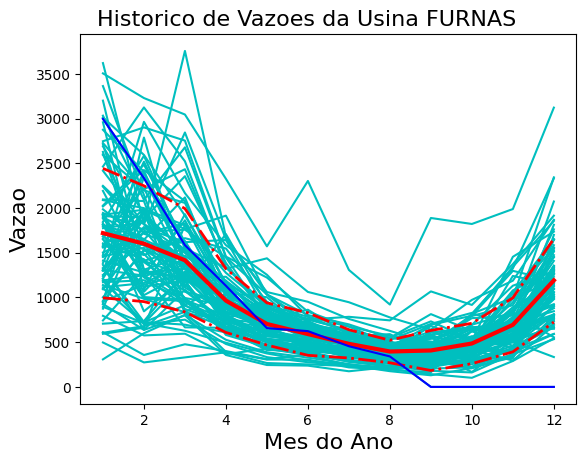

In [10]:
Caso.confhd.plot_vaz(usina)

#### *Vazões Estimadas e Erros na Estimação*

Escolher a ordem que se deseja observar vazoes e erros:

In [11]:
ordem = 3

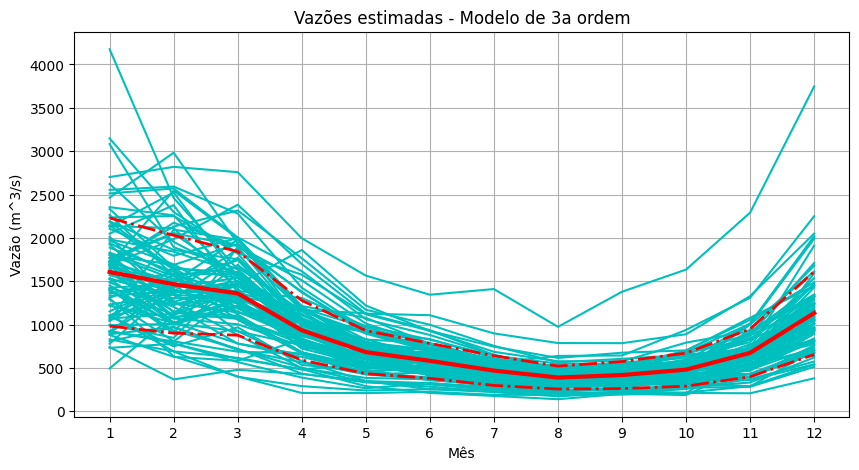

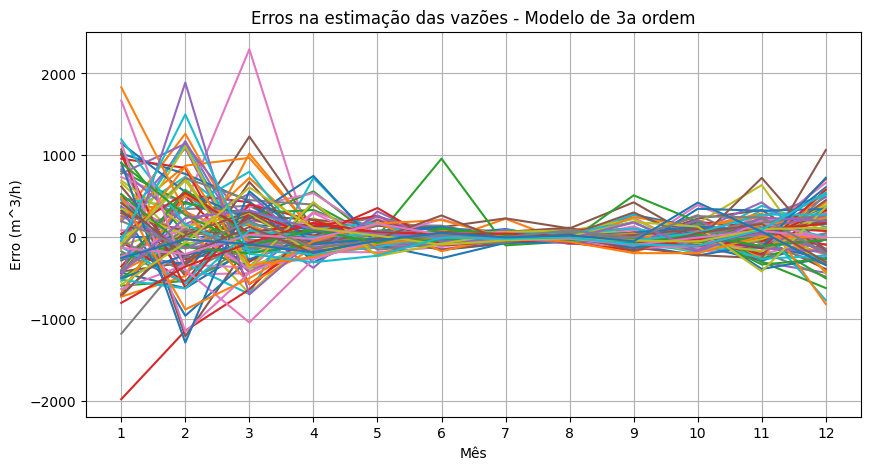

In [12]:
plt.figure(figsize=(10,5))

meses = np.arange(1,12+1,1)

for i,vazoes_est_anuais in enumerate(vazoes_est[ordem-1]):
    if (i > 0):
        plt.plot(meses, vazoes_est_anuais,'c-')

media = np.mean(vazoes_est[ordem-1], axis=0)
plt.plot(meses, media, 'r-', lw=3)
desvio = np.nanstd(vazoes_est[ordem-1], axis=0)
plt.plot(meses, media + desvio, 'r-.', lw=2)
plt.plot(meses, media - desvio, 'r-.', lw=2)

plt.title('Vazões estimadas - Modelo de ' + str(ordem) + 'a ordem')
plt.xlabel('Mês')
plt.ylabel('Vazão (m^3/s)')
plt.xticks(meses)
plt.grid()
plt.show()



plt.figure(figsize=(10,5))

meses = np.arange(1,12+1,1)

for erros_anuais in erros[ordem-1]:
    if (i > 0):
        plt.plot(meses, erros_anuais)

plt.title('Erros na estimação das vazões - Modelo de ' + str(ordem) + 'a ordem')
plt.xlabel('Mês')
plt.ylabel('Erro (m^3/h)')
plt.xticks(meses)
plt.grid()
plt.show()